REF: https://goldcopd.org/wp-content/uploads/2020/03/GOLD-2020-POCKET-GUIDE-ver1.0_FINAL-WMV.pdf
Need to get PFT date difference

exposure and lung function decline

PCA and cluster
- only exposure
    - SO2 TO PM25
    - PCA and K-means -> weights
- All

Correlation:
- PM PCs and exposure vs all PFT changes
- Highlight significant correlated PFT values and T0 and T1

Scatterplot for FEV1, FEV1/FVC, and highly correlated with PM exposure

FEV1/FVC post < 0.7
FEV1/FVC post >=0.7 Gold0
Grade classification 

Find out decreased PFT variables and highlight
compute 1 year change of all PFT variables

Random Forest
- all %pred post 




Correlation between 
- all averaged PM variables and changes in PFT
- changes in PFT and baseline PFT

In [853]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.cluster import KMeans
from utility import *

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [854]:
SUBJID = 'Subj'
ROOT_PATH = '/home/twkim/datascience/'
DATA_PATH = '/home/twkim/datascience/QCT_Pro_20200304.csv'

df_raw = pd.read_csv(DATA_PATH)
df_VZERO = df_raw.filter(regex='0$', axis=1)
df_subj_id = df_raw[SUBJID]

PM_col = [col for col in df_raw.columns if 'PM' in col]
PFT_col = df_raw.columns[12:59].values
DESC_col = ['Age_yr', 'Height_m', 'Weight_kg']

print('# of subjects: ' + str(len(subj_id)))

# of subjects: 138


In [862]:
# Preprocess
df_target = df_VZERO
df_target = remove_inf_and_nan(df_target)
df_target = remove_outlier(df_target,threshold=3.5)


Indices of 24 outliers:  [ 23  27  28  30  32  44  50  52  59  60  66  67  72  74  75  88  98 106
 108 109 110 115 121 125]


In [863]:
PCs, weights = PCA_2(df_target.values)

PC1_df_target = PCs.iloc[:,0].values
PC2_df_target = PCs.iloc[:,1].values
PC_weights_df_target = pd.DataFrame(weights, columns=df_target.columns, index=['PC1', 'PC2'])

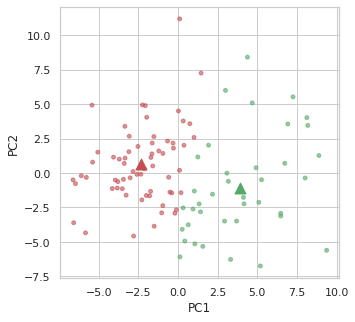

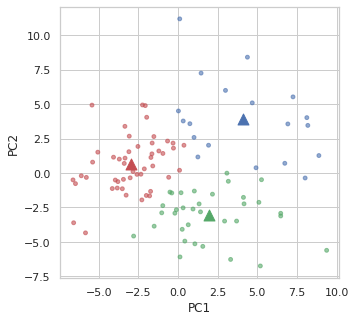

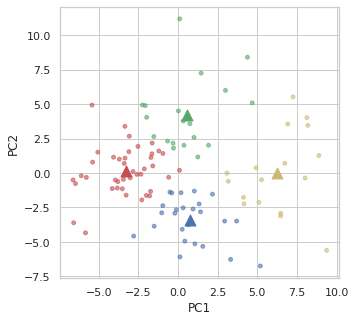

In [864]:
labels2_PC_df_target, centroids2_PC_df_target = K_means(PC1_df_target, PC2_df_target, n=2,plot=True,xlabel='PC1',ylabel='PC2')
labels3_PC_df_target, centroids3_PC_df_target = K_means(PC1_df_target, PC2_df_target, n=3,plot=True,xlabel='PC1',ylabel='PC2')
labels4_PC_df_target, centroids4_PC_df_target = K_means(PC1_df_target, PC2_df_target, n=4,plot=True,xlabel='PC1',ylabel='PC2')

# Correlation: PCs

In [865]:
df_target['PC1'] = PC1_df_target
df_target['PC2'] = PC2_df_target
df_target[SUBJID] = subj_id
df_target = swap_col(df_target)

#fu01['Cluster_PCA, k=2'] = labels2_PC_fu01
#fu01['Cluster_PCA, k=3'] = labels3_PC_fu01
#fu01['Cluster_PCA, k=4'] = labels4_PC_fu01

df_target.head()

,Subj,dAV_U_ML_T0,dAV_UM_L_T0,dAV_xLUL_T0,dAV_xLLL_T0,dAV_xRUL_T0,dAV_xRML_T0,dAV_xRLL_T0,Emph_All_T0,Emph_LUL_T0,Emph_LLL_T0,Emph_RUL_T0,Emph_RML_T0,Emph_RLL_T0,fSAD_All_T0,fSAD_LUL_T0,fSAD_LLL_T0,fSAD_RUL_T0,fSAD_RML_T0,fSAD_RLL_T0,RRAVC_All_T0,RRAVC_LUL_T0,RRAVC_LLL_T0,RRAVC_RUL_T0,RRAVC_RML_T0,RRAVC_RLL_T0,HAA_All_T0,HAA_LUL_T0,HAA_LLL_T0,HAA_RUL_T0,HAA_RML_T0,HAA_RLL_T0,J_All_T0,J_LUL_T0,J_LLL_T0,J_RUL_T0,J_RML_T0,J_RLL_T0,ADI_All_T0,ADI_LUL_T0,ADI_LLL_T0,ADI_RUL_T0,ADI_RML_T0,ADI_RLL_T0,Angle_eTrachea_TLC0,Angle_eRMB_TLC0,Cr_Trachea_TLC0,Cr_RMB_TLC0,Cr_LMB_TLC0,Cr_LLB_TLC0,Cr_BI_TLC0,Cr_sLUL_TLC0,Cr_sRUL_TLC0,Cr_sRLL_TLC0,WTn_Trachea_TLC0,WTn_RMB_TLC0,WTn_LMB_TLC0,WTn_LLB_TLC0,WTn_BI_TLC0,WTn_sLUL_TLC0,WTn_sRUL_TLC0,WTn_sRLL_TLC0,Dhn_Trachea_TLC0,Dhn_RMB_TLC0,Dhn_LMB_TLC0,Dhn_LLB_TLC0,Dhn_BI_TLC0,Dhn_sLUL_TLC0,Dhn_sRUL_TLC0,Dhn_sRLL_TLC0,PC1,PC2
0,PMSN01007,0.836987,1.217892,0.257269,0.186955,0.198361,0.093491,0.263924,0.142149,0.160303,0.088539,0.178179,0.162136,0.117833,0.058745,0.073284,0.004080,0.086880,0.149192,0.015233,0.9863,0.9330,1.1480,0.8936,0.85740,1.101,0.10220,0.08790,0.14200,0.07513,0.08330,0.12305,1.900674,1.849689,2.054045,1.793438,1.750772,2.013699,0.758702,0.584389,0.728960,0.619553,1.053650,0.968989,109.803362,82.754089,0.972623,0.949245,0.946059,0.958102,0.927745,0.934047,0.866068,0.956311,0.483386,0.394665,0.379032,0.344482,0.330564,0.316321,0.326566,0.333224,0.966422,0.783221,0.602703,0.389673,0.628259,0.507333,0.530713,0.399302,-5.781805,-0.318393
1,PMSN01014,0.040171,0.012302,0.048327,0.419923,-0.009708,-0.026467,0.567925,0.190873,0.199872,0.166727,0.194819,0.220050,0.191512,0.442806,0.456149,0.404089,0.422303,0.493350,0.460720,1.2420,0.6600,2.4510,0.4434,0.12115,2.535,0.11430,0.10830,0.13650,0.11163,0.08923,0.11090,0.962636,0.978536,0.945048,0.982111,0.989333,0.943386,0.059193,0.045978,0.065901,0.040846,0.078364,0.070665,110.137871,64.738964,0.978802,0.941644,0.915117,0.962714,0.869970,0.925394,0.894806,0.946730,0.441867,0.436360,0.367295,0.313748,0.342192,0.320868,0.297597,0.309418,1.174519,0.869405,0.740948,0.595684,0.676790,0.622123,0.497141,0.519947,9.375982,-5.613196
2,PMSN01018,0.381656,0.638937,0.204194,0.279120,0.072036,0.113618,0.331032,0.146293,0.142904,0.133944,0.151834,0.175587,0.142588,0.056838,0.057463,0.021571,0.099680,0.153340,0.023607,0.9290,0.8594,1.2170,0.7305,0.75400,1.085,0.14930,0.13540,0.17300,0.14220,0.11000,0.16300,1.453852,1.366707,1.616545,1.283628,1.323672,1.513306,0.378910,0.267481,0.397795,0.267003,0.442498,0.455710,90.252510,56.711391,0.977854,0.819914,0.968310,0.937818,0.909046,0.924952,0.919042,0.912212,0.425827,0.428040,0.316422,0.331236,0.360384,0.296904,0.279097,0.293481,0.978180,1.123615,0.660309,0.424485,0.626911,0.471108,0.367924,0.416727,0.096420,0.199788
3,PMSN01020,0.723476,0.991582,0.241097,0.249442,0.178681,0.078109,0.252672,0.152088,0.162523,0.139327,0.168148,0.172295,0.132277,0.023861,0.018044,0.004622,0.038687,0.086013,0.009637,0.9634,1.0010,1.1370,0.8870,0.76560,1.026,0.11725,0.11510,0.13380,0.10170,0.10266,0.12290,1.954271,1.960128,2.214327,1.791188,1.631402,1.977477,0.478864,0.416123,0.544288,0.445874,0.396793,0.540998,119.161731,62.509373,0.976257,0.852730,0.928575,0.954498,0.857869,0.903532,0.942949,0.821691,0.392475,0.367402,0.366798,0.305181,0.338182,0.328272,0.317173,0.333075,0.864928,0.701752,0.608850,0.466207,0.556207,0.553712,0.522790,0.506440,-3.391119,0.697072
4,PMSN01028,0.536743,0.776575,0.198948,0.228849,0.150325,0.087846,0.334032,0.140591,0.125483,0.142416,0.123419,0.142949,0.157696,0.038306,0.024240,0.041495,0.037269,0.043144,0.044244,0.9785,0.9870,0.9946,0.8940,0.95600,1.062,0.09480,0.10144,0.10205,0.09827,0.09360,0.08350,1.848070,1.802094,1.831024,1.698254,1.754628,1.999399,0.479561,0.452212,0.437939,0.383664,0.579053,0.550864,109.503613,90.980863,0.978528,0.954863,0.928076,0.961057,0.906979,0.902240,0.941942,0.967684,0.441699,0.373956,0.363041,0.343085,0.357421,0.365852,0.323038,0.320383,1.015623,0.810091,0.610777,0.525479,0.652

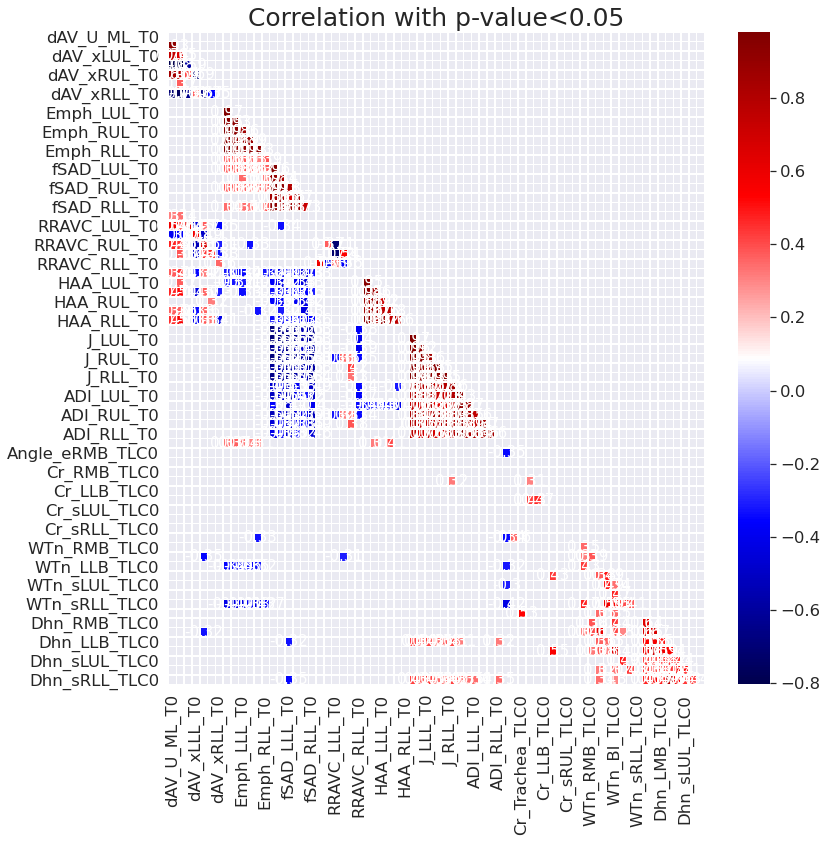

In [867]:
# Pearson
p_corr_target = df_target.corr(method='pearson')
PCA_columns = p_corr_target.columns[:-2]
target_columns = p_corr_target.columns[-2:]
p_corr, p_values = show_cor_heatmap(p_corr_target,43,target_columns,target_columns,symmetric=True,return_pvalue=True)

In [388]:
p_corr.to_excel(ROOT_PATH + 'output_Pro_p_corr.xlsx')
p_values.to_excel(ROOT_PATH + 'output_Pro_p_values.xlsx')